LSTM Tesla Stock Forecaster

In [1]:
import pandas as pd

#Load
tsla = pd.read_csv('TSLA.csv')

# datetime conversion
tsla['Date'] = pd.to_datetime(tsla['Date'])

#'Date' column as index of dataframe
tsla.set_index('Date', inplace=True)

# Checking for duplicate dates
print("Number of duplicate dates:", tsla.index.duplicated().sum())

# Statistical summary
print(tsla.describe())

# SMA's for 10 and 50 days as technical indicators
tsla['SMA_10'] = tsla['Close'].rolling(window=10).mean()
tsla['SMA_50'] = tsla['Close'].rolling(window=50).mean()

# Displaying new SMA columns
print(tsla.head(20))

Number of duplicate dates: 0
              Open         High          Low        Close    Adj Close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean    131.914480   134.953362   128.540340   131.784972   131.784972   
std     118.024908   120.693717   114.974179   117.835854   117.835854   
min      12.073333    12.445333    11.799333    11.931333    11.931333   
25%      21.060001    21.476001    20.643000    21.078333    21.078333   
50%      81.431999    81.866669    79.040001    80.577332    80.577332   
75%     235.556671   239.885003   231.284996   236.125000   236.125000   
max     411.470001   414.496674   405.666656   409.970001   409.970001   

             Volume  
count  1.259000e+03  
mean   1.324330e+08  
std    9.017629e+07  
min    2.940180e+07  
25%    7.578000e+07  
50%    1.016115e+08  
75%    1.543911e+08  
max    9.140820e+08  
                 Open       High        Low      Close  Adj Close     Volume  \
Date                      

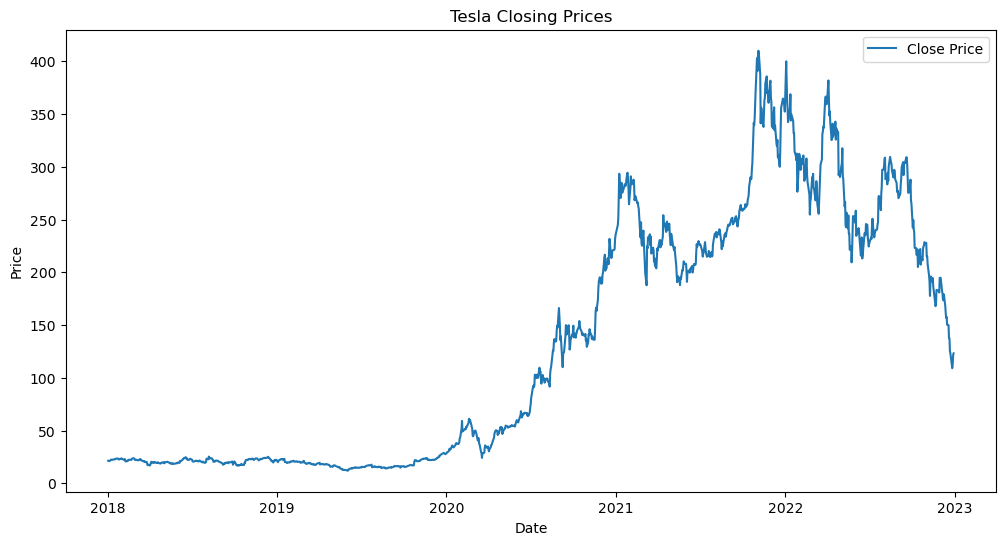

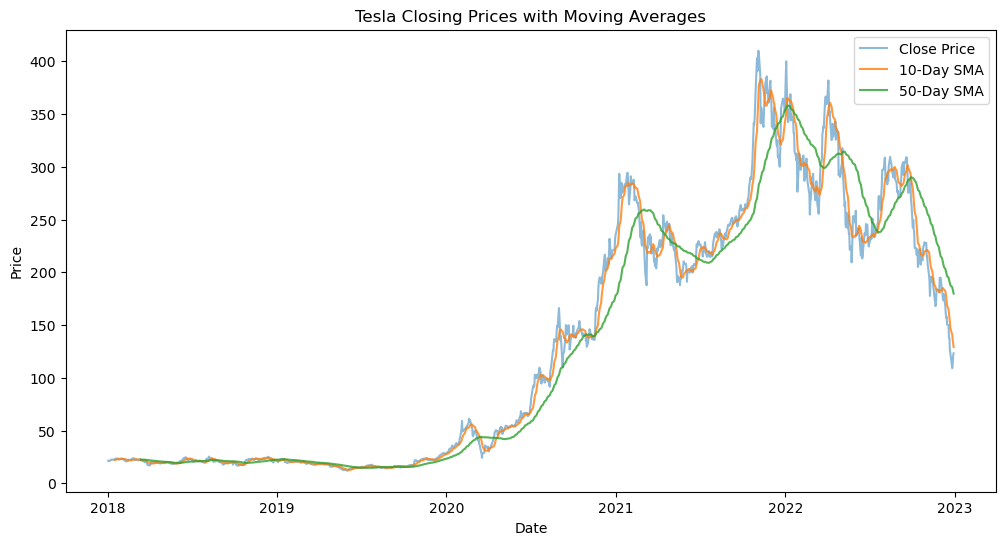

In [2]:
import matplotlib.pyplot as plt

# closing prices plt
plt.figure(figsize=(12,6))
plt.plot(tsla['Close'], label='Close Price')
plt.title('Tesla Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Moving Averages plt
plt.figure(figsize=(12,6))
plt.plot(tsla['Close'], label='Close Price', alpha=0.5)
plt.plot(tsla['SMA_10'], label='10-Day SMA', alpha=0.8)
plt.plot(tsla['SMA_50'], label='50-Day SMA', alpha=0.8)
plt.title('Tesla Closing Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# features to be used
features = ['Close', 'Volume', 'SMA_10', 'SMA_50']
tsla_features = tsla[features].copy()
tsla_features.dropna(inplace=True)  # Dropping rows where SMA values are NaN

# Scaling features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_features)

# create sequences for LSTM
def create_sequences(data, sequence_length=60):
    xs, ys = [], []
    for i in range(len(data)-sequence_length):
        x = data[i:(i+sequence_length)]
        y = data[i+sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
sequence_length = 60  # Num days in sequence
X, y = create_sequences(scaled_data, sequence_length)

# Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [4]:
# Building + Training
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Reshape features for LSTM Layer
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

# Build
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], len(features))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting one value

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
29/29 [==============================] - 2s 26ms/step - loss: 0.0189
Epoch 2/50
29/29 [==============================] - 1s 27ms/step - loss: 0.0043
Epoch 3/50
29/29 [==============================] - 1s 25ms/step - loss: 0.0038
Epoch 4/50
29/29 [==============================] - 1s 27ms/step - loss: 0.0028
Epoch 5/50
29/29 [==============================] - 1s 25ms/step - loss: 0.0031
Epoch 6/50
29/29 [==============================] - 1s 25ms/step - loss: 0.0030
Epoch 7/50
29/29 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 8/50
29/29 [==============================] - 1s 29ms/step - loss: 0.0025
Epoch 9/50
29/29 [==============================] - 1s 26ms/step - loss: 0.0023
Epoch 10/50
29/29 [==============================] - 1s 24ms/step - loss: 0.0027
Epoch 11/50
29/29 [==============================] - 1s 28ms/step - loss: 0.0022
Epoch 12/50
29/29 [==============================] - 1s 26ms/step - loss: 0.0023
Epoch 13/50
29/29 [==================

8/8 [==============================] - 0s 9ms/step


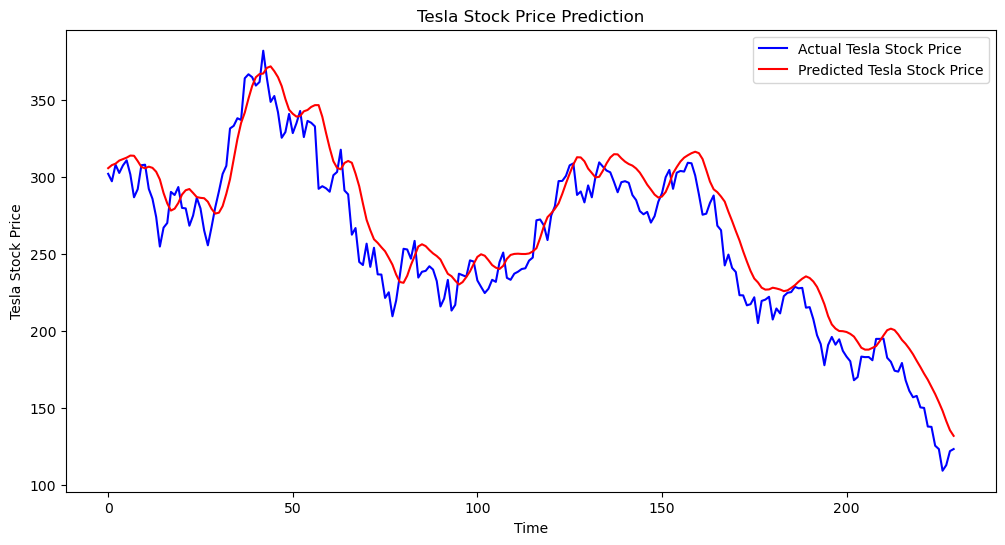

In [5]:
# Eval + Predictions

predicted_stock_price = model.predict(X_test)

# Inverse transform for y_test to get the actual prices back
actual_prices = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:,0]

# Inverse transform for the predicted stock prices
predicted_stock_price = scaler.inverse_transform(np.concatenate((predicted_stock_price.reshape(-1, 1), np.zeros((predicted_stock_price.shape[0], len(features) - 1))), axis=1))[:,0]

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual_prices, color='blue', label='Actual Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100
# MAE, MSE, RMSE using the inverse-transformed actual and predicted prices
mape = calculate_mape(actual_prices, predicted_stock_price)
mae = mean_absolute_error(actual_prices, predicted_stock_price)
mse = mean_squared_error(actual_prices, predicted_stock_price)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Absolute Error (MAE): 15.900808225618638
Mean Squared Error (MSE): 369.99450218676685
Root Mean Squared Error (RMSE): 19.23524115229042
Mean Absolute Percentage Error (MAPE): 6.882510234585915%
